
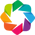

In [47]:
import matplotlib
import poloniex
import datetime
import holoviews as hv
from holoviews.operation.timeseries import rolling, rolling_outlier_std
from holoviews.streams import Stream
hv.notebook_extension('bokeh')

## Fetching and Visualizing data

In [4]:
#import plotly
#plotly.offline.init_notebook_mode()
#from plotly.offline import iplot 
#import plotly.graph_objs as go
import backtrader
import pandas as pd
# hv.notebook_extension('matplotlib')

Let's Start by checking your balances. You need to have your keys stored somewhere the bitfinex client can find.

Let's Download some historic series:

In [3]:
# wget.download('http://api.bitcoincharts.com/v1/csv/bitfinexUSD.csv.gz','bitfinexUSD.csv.gz')

In [4]:
# bitcoin = pd.read_csv('http://api.bitcoincharts.com/v1/csv/bitfinexUSD.csv.gz', compression='gzip')

In [5]:
# bitcoin.columns = ['datetime', 'price', 'volume']
# bitcoin['datetime'] = pd.to_datetime(bitcoin.datetime, unit='s')
# bitcoin.set_index(['datetime'], inplace=True)
# bitcoin.head()

In [37]:
end = datetime.datetime.now()
start = end - datetime.timedelta(days=364)
ether = poloniex.get_ohlc('USDT_ETH',start, end)
btc = poloniex.get_ohlc('USDT_BTC', start,end)

In [39]:
ether.describe()

close           high            low           open  \
count  104832.000000  104832.000000  104832.000000  104832.000000   
mean      148.134969     148.535753     147.718852     148.141360   
std       130.758800     131.088919     130.412538     130.767577   
min         5.883966       5.964728       5.854031       5.900000   
25%        11.337488      11.350000      11.325000      11.339117   
50%        92.005495      92.259760      91.800680      92.000140   
75%       291.120000     291.900000     290.447765     291.190017   
max       405.000000     408.128700     395.800000     405.000000   

         quoteVolume        volume  weightedAverage  
count  104832.000000  1.048320e+05    104832.000000  
mean      203.614565  3.349293e+04       148.124706  
std       463.406237  8.085904e+04       130.747506  
min         0.000000  0.000000e+00         5.900298  
25%         6.593947  1.862298e+02        11.339102  
50%        53.586699  6.209774e+03        92.010250  
75%       198.996628  3.094005e+04       291.140754  
max     13335.125868  2.630736e+06       399.911100

In [40]:
def load_symbol(symbol, **kwargs):
    df = data[symbol]
    df.reset_index(level=0, inplace=True)
    return hv.Curve(df, ('date', 'Date'), ('close', 'Close price'))

stock_symbols = ['ETH', 'BTC',]
data = {"ETH": ether, 'BTC':btc}
dmap = hv.DynamicMap(load_symbol, kdims='Symbol').redim.values(Symbol=stock_symbols)

In [41]:
%%opts Curve [width=600] {+framewise}
dmap

:DynamicMap   [Symbol]

In [27]:
%%opts Scatter [width=600] (color='black')
smoothed = dmap*rolling(dmap, rolling_window=30)*rolling_outlier_std(dmap)
smoothed

:DynamicMap   [Symbol]

# Creating a strategy

From now on we are going to use the [backtrader](https://www.backtrader.com/docu/index.html) library to implent algirithmic strategies to trade Ether. 

In [10]:
import backtrader as bt
import backtrader.indicators as btind
import backtrader.analyzers as btanalyzers

In [11]:
def run_test():
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    res = cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    return res

In [12]:
class SMA_CrossOver(backtrader.Strategy):

    params = (('fast', 12), ('slow', 26))

    def __init__(self):
        self.rsi = btind.RSI()
        sma_fast = btind.SMA(period=self.p.fast)
        sma_slow = btind.SMA(period=self.p.slow)

        self.buysig = btind.CrossOver(sma_fast, sma_slow)

    def next(self):
        if self.position.size:
#             if (self.buysig < 0):
#                 self.sell()

#       elif (self.buysig > 0):
#                 self.buy()
            if (self.rsi<=50):
                self.sell()

        elif (self.rsi>=60):
            self.buy()
            
class Aroon(backtrader.Strategy):
    params = (('period',70),)
    def __init__(self):
        self.a_up = btind.AroonUp(period=self.p.period)
        self.a_down = btind.AroonDown(period=self.p.period)
    def next(self):
        if self.position.size:
            if self.a_down >= 95:
                self.sell()
        elif self.a_up >=97:
            self.buy()

In [23]:
class MarcosStrat(backtrader.Strategy):
    def __init__(self):
        self.delta = 5
        self.price_in = None
        self.price_out = 100000
        self.trailing = 0.5
        self.target = 10000000
        self.order = None
        print(self.position.size)
        
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enougth cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f, %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm,
                     self.price_out))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        
    def next(self):
#         if self.order:
#             print(self.order)
#             return
        self.price_out = self.data.close[0] if self.price_out is None else self.price_out
        for data in self.datas:
            curpos = self.getposition(data)
            if curpos.size:
                #self.price_in = self.data.close[0] if self.price_in is None else self.price_in

                if self.data.close[0] - self.price_in >= self.delta:
#                     print("Sell. Price: {}, price_out: {}, price_in:{}".format(self.data.close[0],self.price_out, self.price_in))
                    size = curpos.size // 2
                    self.order = self.sell(data=data, size=size)
#                     print("Position:", self.position.size)
                    self.price_out = self.data.close[0]

            if self.data.close[0] - self.price_out <= -self.delta:

    #             print("Buying: {}. Price: {}, price_out: {}, price_in:{}".format(self.position.size,self.data.close[0],self.price_out, self.price_in))

                #self.target =  self.data.close+self.trailing if self.data.close < self.target else self.target 
                #if self.data.close >= self.target:
                self.order = self.buy(data=data,
                                      exectype=bt.Order.Limit, 
                                      price=self.data.close[0] * 1.02)
                self.price_in = self.data.close[0]

In [25]:
cerebro = backtrader.Cerebro()
cerebro.broker.setcash(100000.0)
data2 = backtrader.feeds.PandasData(dataname=ether[-1500:], datetime=None)
cerebro.adddata(data2)
cerebro.broker.setcommission(commission=0.001)
cerebro.addsizer(backtrader.sizers.FixedSize, stake=10)
# cerebro.addstrategy(SMA_CrossOver)
cerebro.addstrategy(MarcosStrat)
cerebro.addanalyzer(bt.analyzers.PyFolio)
#cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
res = run_test()
#print('Sharpe Ratio:', res[0].analyzers.mysharpe.get_analysis())

Starting Portfolio Value: 100000.00
0
2017-07-28, BUY EXECUTED, Price: 200.28, Cost: 2002.78, Comm 2.00, 100000.00
2017-07-28, BUY EXECUTED, Price: 199.81, Cost: 1998.12, Comm 2.00, 100000.00
2017-07-28, BUY EXECUTED, Price: 199.51, Cost: 1995.09, Comm 2.00, 100000.00
2017-07-28, BUY EXECUTED, Price: 199.45, Cost: 1994.47, Comm 1.99, 100000.00
2017-07-28, BUY EXECUTED, Price: 200.00, Cost: 2000.00, Comm 2.00, 100000.00
2017-07-28, BUY EXECUTED, Price: 200.00, Cost: 2000.00, Comm 2.00, 100000.00
2017-07-28, BUY EXECUTED, Price: 199.30, Cost: 1993.00, Comm 1.99, 100000.00
2017-07-28, BUY EXECUTED, Price: 199.30, Cost: 1993.00, Comm 1.99, 100000.00
2017-07-28, BUY EXECUTED, Price: 199.00, Cost: 1990.00, Comm 1.99, 100000.00
2017-07-28, BUY EXECUTED, Price: 199.40, Cost: 1994.00, Comm 1.99, 100000.00
2017-07-28, BUY EXECUTED, Price: 198.77, Cost: 1987.70, Comm 1.99, 100000.00
2017-07-28, BUY EXECUTED, Price: 197.91, Cost: 1979.10, Comm 1.98, 100000.00
2017-07-28, BUY EXECUTED, Price: 197.3

2017-07-29, Order Canceled/Margin/Rejected
2017-07-29, Order Canceled/Margin/Rejected
2017-07-29, Order Canceled/Margin/Rejected
2017-07-29, Order Canceled/Margin/Rejected
2017-07-29, Order Canceled/Margin/Rejected
2017-07-29, Order Canceled/Margin/Rejected
2017-07-29, Order Canceled/Margin/Rejected
2017-07-29, Order Canceled/Margin/Rejected
2017-07-29, Order Canceled/Margin/Rejected
2017-07-29, Order Canceled/Margin/Rejected
2017-07-29, Order Canceled/Margin/Rejected
2017-07-29, Order Canceled/Margin/Rejected
2017-07-29, Order Canceled/Margin/Rejected
2017-07-29, Order Canceled/Margin/Rejected
2017-07-29, Order Canceled/Margin/Rejected
2017-07-29, Order Canceled/Margin/Rejected
2017-07-29, Order Canceled/Margin/Rejected
2017-07-29, Order Canceled/Margin/Rejected
2017-07-29, Order Canceled/Margin/Rejected
2017-07-29, Order Canceled/Margin/Rejected
2017-07-29, Order Canceled/Margin/Rejected
2017-07-29, Order Canceled/Margin/Rejected
2017-07-29, Order Canceled/Margin/Rejected
2017-07-29,

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1405: UserWarning:


This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.




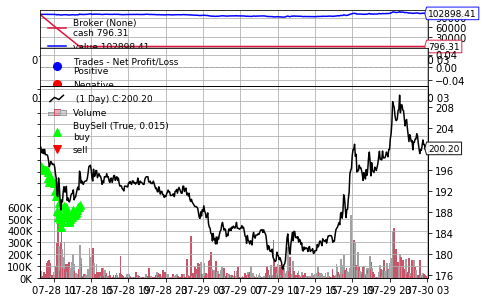

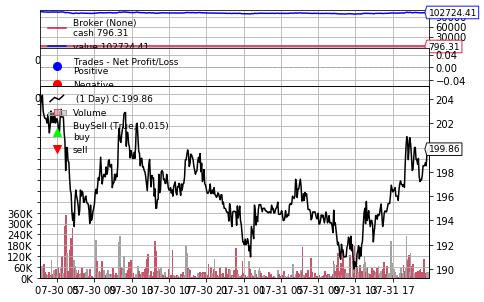

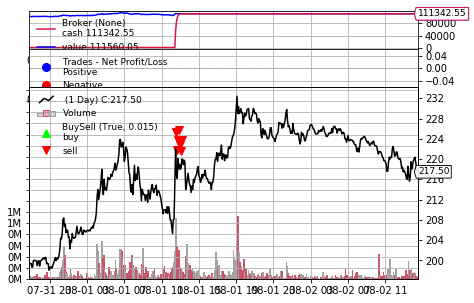

In [26]:
cerebro.plot(numfigs=3);

In [16]:
pyfoliozer = res[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

In [17]:
res

In [20]:
import pyfolio as pf
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
#     gross_lev=gross_lev,
    live_start_date='2016-07-26',  # This date is sample specific
    round_trips=True)


AttributeError: module 'theano' has no attribute 'gof'